## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [110]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [111]:
# ваш код здесь

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


Столбец date имеет тип данных object

## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [112]:
# ваш код здесь

data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d') #приведение параметра date к формату datetime

#определение начальной и конечной даты проведения тестирования в группах
min_date_a = data[data['group']=='A']['date'].min()
max_date_a = data[data['group']=='A']['date'].max()
min_date_b = data[data['group']=='B']['date'].min()
max_date_b = data[data['group']=='B']['date'].max()

#сравнения длительности проведения тестирования в группах
print(min_date_a == min_date_b)
print(max_date_a == max_date_b)
print('Начало тестирования в обеих группах:', min_date_a, '\n', 'Окончание тестирования в обеих группах:', max_date_a)

True
True
Начало тестирования в обеих группах: 2021-01-02 00:00:00 
 Окончание тестирования в обеих группах: 2021-01-24 00:00:00


Длительность тестирования в обеих группах одинаковая.
Тестирование проводилось в обеих группах с 2021.01.02 по 2021.01.24

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [113]:
# ваш код здесь

#определение количества визитов в группах
visit_a = data[data['group']=='A']['purchase'].count()
visit_b = data[data['group']=='B']['purchase'].count()
print('Количество посещений сайта в группе А:', visit_a)
print('Количество посещений сайта в группе B:', visit_b)

#определение количества покупок в группах
purchase_a = data[(data['group'] == 'A') & (data['purchase'] == 1)]['purchase'].count()
purchase_b = data[(data['group'] == 'B') & (data['purchase'] == 1)]['purchase'].count()
print('Количество покупок в группе А:', purchase_a)
print('Количество покупок в группе B:', purchase_b)

#определение суммы покупок в группах
sum_a = data[data['group']=='A']['price'].sum()/1000000
sum_b = data[data['group']=='B']['price'].sum()/1000000
print('Сумма покупок в группе А:', sum_a, 'млн.р')
print('Сумма покупок в группе B:', sum_b, 'млн.р')


Количество посещений сайта в группе А: 147202
Количество посещений сайта в группе B: 147276
Количество покупок в группе А: 17723
Количество покупок в группе B: 17514
Сумма покупок в группе А: 1436.26 млн.р
Сумма покупок в группе B: 1554.1 млн.р


Согласно проведенным расчетам, между группами наблюдается небольшо различие в количестве посещений сайта, количестве покупок и сумме покупок.

## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [114]:
# ваш код здесь

#создание множеств пользователей по группам
users_a = set(data[data['group']=='A']['user_id'])
users_b = set(data[data['group']=='B']['user_id'])

#пересечение множеств для оценки количества пользователей, попавших в обе группы
users_all = users_a.intersection(users_b)

print('Количество пользователей в группе А:', len(users_a))
print('Количество пользователей в группе B:', len(users_b))
print('Количество пользователей, поавших в обе группы:', len(users_all))

Количество пользователей в группе А: 146195
Количество пользователей в группе B: 146284
Количество пользователей, поавших в обе группы: 1895


Проведенные расчеты показывают, что в обоих группах присутствует 1895 одних и тех же пользователей, что неиобходимо исключить.

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [115]:
updated_data = data[data['user_id'].apply(lambda x: x not in users_all)]

Где users_all - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

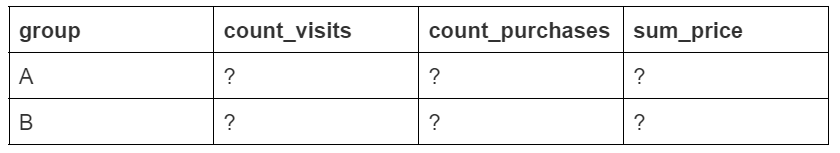
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [116]:
# ваш код здесь

updated_data = updated_data.groupby(['group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price': 'sum'
}).reset_index().rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price':'sum_price'})
updated_data.head()

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

Проведенные расчеты показывают, что посещение обоих вариантов посадочной страницы сопоставимы - количество визитов различается незначительно, примерно на 0,05%.
Выборки можно считать сбалансированными.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [117]:
# ваш код здесь

#создание дополнительных колонок для групп сравнения
updated_data['conversion'] = updated_data['count_purchases'] / updated_data['count_visits']
updated_data['mean_chek'] = updated_data['sum_price'] / updated_data['count_purchases']

updated_data.head()

,group,count_visits,count_purchases,sum_price,conversion,mean_chek
0,A,145307,17487,1417780000,0.120345,81076.228055
1,B,145381,17290,1533010000,0.118929,88664.545980


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

Данные, приведенные в таблице указывают на то, что практически при одинаковой конверсии в обоих группах наблюдается различие по среднему чеку, примерно на 8,5%!

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [118]:
updated_data_f = data[data['user_id'].apply(lambda x: x not in users_all)]

In [119]:
# ваш код здесь

# группирование туров по группам
pivot = updated_data_f[updated_data_f['price'] > 0].pivot_table(
    index='group', 
    columns='price', 
    values='purchase', 
    aggfunc='sum'
)
pivot.head()

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

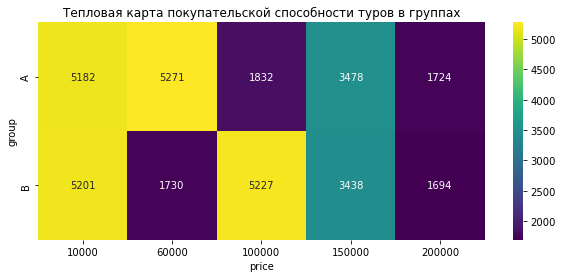

In [120]:

# тепловой график распределения купленных туров в группах
fig = plt.figure(figsize=(10, 4))
ax = sns.heatmap(pivot, fmt='.0f', annot=True, cmap='viridis');
ax.set_title('Тепловая карта покупательской способности туров в группах');

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

Покупательская способность участников группы А выше, чем участников группы B по турам 60000 (Турция).
Покупательская способность участников группы В выше, чем участников группы А по турам 100000 (Таиланд).
Покупательская способность участников обеих групп по остальным турам примерно одинаковая.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [121]:
# группирование по группам и дате

group_2 = updated_data_f.groupby(['group', 'date']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price': 'sum'
}).reset_index()
group_2.head()

,group,date,user_id,purchase,price
0,A,2021-01-02,2854,359,29410000
1,A,2021-01-03,6596,748,62000000
2,A,2021-01-04,6566,799,64250000
3,A,2021-01-05,6433,790,64550000
4,A,2021-01-06,6606,764,63410000


In [122]:
#добавление столбцов
group_2['conv'] = group_2['purchase'] / group_2['user_id']
group_2['mean_chek'] = group_2['price'] / group_2['purchase']
group_2.head()

,group,date,user_id,purchase,price,conv,mean_chek
0,A,2021-01-02,2854,359,29410000,0.125788,81922.005571
1,A,2021-01-03,6596,748,62000000,0.113402,82887.700535
2,A,2021-01-04,6566,799,64250000,0.121687,80413.016270
3,A,2021-01-05,6433,790,64550000,0.122804,81708.860759
4,A,2021-01-06,6606,764,63410000,0.115652,82997.382199


In [123]:
#вывод конверсии и среднего чека в указанную дату
group_2[(group_2['group'] == 'A') & (group_2['date'] == '2021-01-03')]['conv'],\
group_2[(group_2['group'] == 'B') & (group_2['date'] == '2021-01-03')]['conv'],\
group_2[(group_2['group'] == 'A') & (group_2['date'] == '2021-01-03')]['mean_chek'], \
group_2[(group_2['group'] == 'B') & (group_2['date'] == '2021-01-03')]['mean_chek']


(1    0.113402
 Name: conv, dtype: float64,
 24    0.113914
 Name: conv, dtype: float64,
 1    82887.700535
 Name: mean_chek, dtype: float64,
 24    87480.106101
 Name: mean_chek, dtype: float64)

## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [124]:

# вычисляем кумулятивную сумму количества посетителей
group_2['cum_users'] = group_2.groupby(['group'])['user_id'].cumsum()

# вычисляем кумулятивную количество покупок
group_2['cum_pur'] = group_2.groupby(['group'])['purchase'].cumsum()

# вычисляем кумулятивную сумму покупок
group_2['cum_buy'] = group_2.groupby(['group'])['price'].cumsum()

group_2.head()

,group,date,user_id,purchase,price,conv,mean_chek,cum_users,cum_pur,cum_buy
0,A,2021-01-02,2854,359,29410000,0.125788,81922.005571,2854,359,29410000
1,A,2021-01-03,6596,748,62000000,0.113402,82887.700535,9450,1107,91410000
2,A,2021-01-04,6566,799,64250000,0.121687,80413.016270,16016,1906,155660000
3,A,2021-01-05,6433,790,64550000,0.122804,81708.860759,22449,2696,220210000
4,A,2021-01-06,6606,764,63410000,0.115652,82997.382199,29055,3460,283620000


In [125]:
#расчет кумулятивной конверсии
group_2['cum_conv'] = group_2['cum_pur']/group_2['cum_users']

#расчет кумулятивного среднего чека
group_2['cum_mean_chek'] = group_2['cum_buy']/group_2['cum_pur']

group_2.head()

,group,date,user_id,purchase,price,conv,mean_chek,cum_users,cum_pur,cum_buy,cum_conv,cum_mean_chek
0,A,2021-01-02,2854,359,29410000,0.125788,81922.005571,2854,359,29410000,0.125788,81922.005571
1,A,2021-01-03,6596,748,62000000,0.113402,82887.700535,9450,1107,91410000,0.117143,82574.525745
2,A,2021-01-04,6566,799,64250000,0.121687,80413.016270,16016,1906,155660000,0.119006,81668.415530
3,A,2021-01-05,6433,790,64550000,0.122804,81708.860759,22449,2696,220210000,0.120094,81680.267062
4,A,2021-01-06,6606,764,63410000,0.115652,82997.382199,29055,3460,283620000,0.119084,81971.098266


In [126]:
#вывод конверсии и среднего чека в указанную дату
group_2[(group_2['group'] == 'B') & (group_2['date'] == '2021-01-20')]['cum_conv']*100,\
group_2[(group_2['group'] == 'A') & (group_2['date'] == '2021-01-12')]['cum_mean_chek']

(41    11.895911
 Name: cum_conv, dtype: float64,
 10    81491.827275
 Name: cum_mean_chek, dtype: float64)

Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

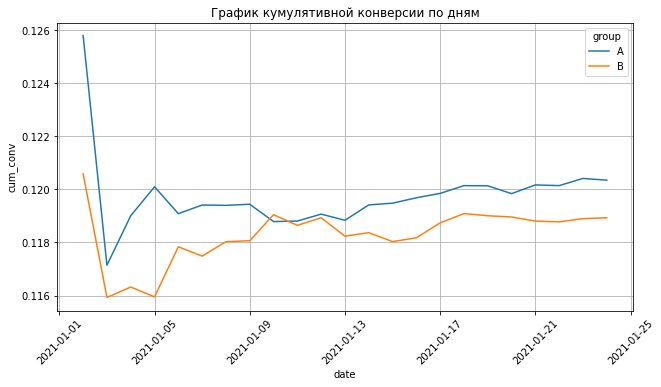

In [127]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conv', data=group_2, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

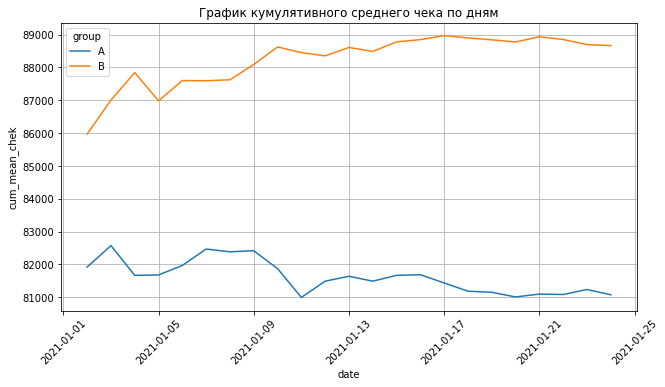

In [128]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_mean_chek', data=group_2, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивного среднего чека по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

Построенные графики указывают, что А/В тестирование можно назвать завершенным, так как метрики (конверсия и сердний чек) в группах стабилизировались.
Кумулятивная конверсия в группе А выше, чем в группе В. В тоже время, кумулятивный средний чек в группе В больше, чем в группе А.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [129]:
converted_piv= updated_data_f.groupby('group')['purchase'].agg(
    ['sum', 'count']
)
converted_piv.head()

,sum,count
group,,
A,17487,145307
B,17290,145381


In [130]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А больше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

Для оценки статистической значимости используется z-тест, так как количество наблюдений более 30.
Согласно расчет статистической разницы между конверсиями в группах А и В нет.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [131]:
from scipy.stats import t

In [132]:
#фильтруем данные группы А
a_data = updated_data_f[updated_data_f['group'] == 'A']
#фильтруем данные группы B
b_data = updated_data_f[updated_data_f['group'] == 'B']

In [133]:
#функция для расчета границ доверительного интервала

def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [134]:
#расчет доверительных интервалов

conf_interval_a = proportions_conf_interval(
n=a_data['user_id'].count(), # размер выборки
x_p=a_data['purchase'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['user_id'].count(), # размер выборки
x_p=b_data['purchase'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [135]:
#функция для расчета разности между доверительными интервалами

def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

In [136]:
# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

Доверительные интервалы конверсий имеют близкие границы. Между данными интервалами есть перекрытие.
Построенный доверительный интервал с 95 %-ой надёжностью говорит нам, что разница в конверсии между вариантом B и вариантом А лежит в интервале от -0.38 % до 0.09 %.
Пересечние конверий имеет левую отрицательную границу и правую положительную границы, то есть варианты А и В равнозначны по конверсии, статистической разницы в конверсии между вариантами А и B не существует.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [137]:
# гипотезы о нормальности распределения
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (отвергаем H0)'

In [138]:
alpha = 0.05

In [139]:
#примененеие теста Шапиро-Уилка для определения нормальности распределения
from scipy.stats import shapiro

In [140]:
#формирование выборок
group_a = group_2[group_2['group'] == 'A']['mean_chek']
group_b = group_2[group_2['group'] == 'B']['mean_chek']

In [141]:
#проверка на нормальность среднего чека в группе А

_, p = shapiro(group_a)
print('p=%.3f' % p)

# Интерпретация 

if p > alpha:
	print(H0)
else:
	print(Ha)

p=0.253
Данные распределены нормально


In [142]:
#проверка на нормальность среднего чека в группе В
_, p = shapiro(group_b)
print('p=%.3f' % p)

# Интерпретация 

if p > alpha:
	print(H0)
else:
	print(Ha)

p=0.094
Данные распределены нормально


В обеих группах метрика - средний чек распределена нормально.

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [143]:
from scipy.stats import ttest_ind

In [144]:
H0 = 'Ежедневные средние чеки в группах А и B равны'
Ha = 'Ежедневный средний чек в группе А меньше чем в группе B'

In [145]:
alpha = 0.05

In [146]:
def t_test(group_a, group_b):
    test_results = ttest_ind(group_a, group_b, equal_var=True)

    p = round(test_results[1],2)

    if p>alpha:
        print(f"{p} > {alpha}. Мы не можем отвергнуть нулевую гипотезу. {H0}")
    else:
        print(f"{p} <= {alpha}. Мы отвергаем нулевую гипотезу. {Ha}")

t_test(group_a, group_b)

0.0 <= 0.05. Мы отвергаем нулевую гипотезу. Ежедневный средний чек в группе А меньше чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

Полученные результаты говорят о том, что есть статистическая разница между ежедневными средними чеками в группах.
Ранее проведенные анализы подтвердили, что средний чек в группе А меньше, чем в группе В при одинаковой конверсии.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

In [147]:
a_data = group_2[group_2['group'] == 'A']
b_data = group_2[group_2['group'] == 'B']

In [148]:
def confidence_interval(n, x_p, x_std, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    eps = t_crit * x_std/(n ** 0.5) # погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound, 2), round(upper_bound, 2)

In [149]:
import statistics 

In [150]:
n = a_data['user_id'].count() # размер выборки
k = n - 1 # число степеней свободы
x_mean_a = statistics.mean(a_data['mean_chek']) # выборочное среднее
x_mean_b = statistics.mean(b_data['mean_chek'])
x_std_a = statistics.stdev(a_data['mean_chek']) # выборочное стандартное отклонение
x_std_b = statistics.stdev(b_data['mean_chek'])
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

In [151]:
from scipy.stats import t
t_crit = -t.ppf(alpha/2, k) # t-критическое

In [152]:
conf_interval_a = confidence_interval(
n=n, # размер выборки
x_std = x_std_a, # выборочное стандартное отклонение
x_p=x_mean_a # выборочная пропорция
)
conf_interval_b = confidence_interval(
n=n, # размер выборки
x_std = x_std_b,
x_p=x_mean_b # выборочная пропорция
)
print('Доверительный интервал для среднего чека группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для среднего чека группы B: {}'.format(conf_interval_b))

Доверительный интервал для среднего чека группы А: (79630.35, 82308.22)
Доверительный интервал для среднего чека группы B: (87625.83, 89525.61)


Полученные интервалы указывают, что в группе В  абсолютное значение среднего чека выше, чем в группе А.
Таким образом при одинаковой конверсии в обеих группах заметно различается средний чек, и в группе В доверительный интервал имеет больший показатель.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

### Конверсия для обоих вариантов дизайна (А и В) посадочной страницы одинаковая .
### При этом полученные результаты анализа данной выборки указывают на nj, что дизайн посадочной страницы В обеспечивает более высокое значение среднего чека, по сравнению с исходным вариантом дизайна посадочной страницы А.
### Таким образом, дизайн посадочной тсраницы В более выгоден, чем дизайн страницы А.